
## CNN Implementation

## Date: 08/03/2025

This notebook includes data preparation, exploratory data analysis (EDA), data preprocessing, feature extraction, and the implementation of multiple deep learning models: CNN

For each model, we performed model building, training, evaluation, and hyperparameter tuning using grid search to identify the optimal configuration. The final versions of the models were saved as:

*	cnn_model.keras

For CNN and Bidirectional LSTM, the feature-augmented dataset is located at [text](<../featured datasets/chunked_midi_features.csv>)

Requirements: We used an AWS SageMaker ml.p3.2xlarge instance to train and fine-tune the LSTM and Bidirectional LSTM models. 
The workspace required approximately 20 GB of storage for managing the MIDI dataset, processed feature files, and model checkpoints during training and evaluation.

In [21]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs: []


In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [5]:
import torch
torch.cuda.empty_cache()

In [4]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Suppress specific pretty_midi warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.")

### Data Preparation - Load MIDI and Extract Piano Roll

In [5]:
import pretty_midi
import numpy as np

def midi_to_pianoroll(filepath, fs=20):
    """
    Converts MIDI file to piano roll.
    Args:
        filepath: Path to MIDI file
        fs: Frame rate (time steps per second)
    Returns:
        piano_roll: (128, T) numpy array
    """
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        piano_roll = midi.get_piano_roll(fs=fs)  # shape (128, T)
        return piano_roll
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

Here are the steps performed ,

•	Read all MIDI files from your selectedcomposers directory,

•	Convert them to piano roll format,

•	Apply chunking (overlapping with a hop size=50),

•	Normalize the data, encode the labels, and

•	Split into training and test sets.

In [6]:
# Apply chunking i.e., overlapping chunks with hop-size =50
def chunk_pianoroll(piano_roll, chunk_length=100, hop_size=50):
    """
    Splits piano roll into multiple chunks of fixed length.
    Returns a list of 2D arrays (each of shape 100×128 transposed).
    """
    chunks = []
    total_time = piano_roll.shape[1]
    for start in range(0, total_time - chunk_length + 1, hop_size):
        chunk = piano_roll[:, start:start+chunk_length]
        if chunk.shape[1] == chunk_length:
            chunks.append(chunk.T)  # shape (100, 128)
    return chunks

In [7]:
## Process MIDI Directory
data = []
labels = []
base_dir = '../selectedcomposers'  # Adjust path as needed

for composer in os.listdir(base_dir):
    composer_dir = os.path.join(base_dir, composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith('.mid'):
                full_path = os.path.join(composer_dir, file)
                pr = midi_to_pianoroll(full_path)
                if pr is not None:
                    chunks = chunk_pianoroll(pr, chunk_length=100, hop_size=50)
                    data.extend(chunks)
                    labels.extend([composer] * len(chunks))

In [12]:
# # Standardize Time Dimension (Chunk or Pad)
# def standardize_pianoroll(piano_roll, fixed_length=100):
#     if piano_roll.shape[1] >= fixed_length:
#         return piano_roll[:, :fixed_length]  # crop
#     else:
#         # zero-pad at the end
#         padding = np.zeros((128, fixed_length - piano_roll.shape[1]))
#         return np.hstack((piano_roll, padding))

In [13]:
# # Convert All MIDI Files
# import os

# data = []
# labels = []

# base_dir = '../selectedcomposers'  # Update this to your folder name

# for composer in os.listdir(base_dir):
#     composer_dir = os.path.join(base_dir, composer)
#     if os.path.isdir(composer_dir):
#         for file in os.listdir(composer_dir):
#             if file.endswith('.mid'):
#                 full_path = os.path.join(composer_dir, file)
#                 pr = midi_to_pianoroll(full_path)
#                 if pr is not None:
#                     standardized = standardize_pianoroll(pr)
#                     data.append(standardized.T)  # (time_steps, 128)
#                     labels.append(composer)

In [8]:
# Convert to numpy arrays
import numpy as np

X = np.array(data)                  # Shape: (samples, time_steps, 128)
y = np.array(labels)               # Composer names

### Train and Test split

In [9]:
# Encode Labels & Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [10]:
from collections import Counter
print(Counter(y_train))

Counter({1: 14651, 0: 13110, 2: 9430, 3: 8071})


In [11]:
print(f"Total samples: {len(data)}")
print(f"Shape of one sample: {data[0].shape}")

Total samples: 56578
Shape of one sample: (100, 128)


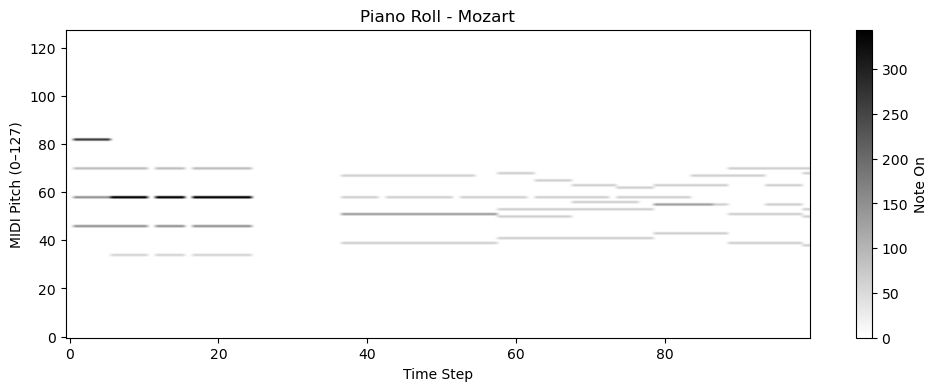

In [18]:
# Visualize piano roll as an image (10th observation foe example)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.imshow(data[10].T, aspect='auto', origin='lower', cmap='gray_r')
plt.title(f"Piano Roll - {labels[0]}")
plt.xlabel("Time Step")
plt.ylabel("MIDI Pitch (0–127)")
plt.colorbar(label="Note On")
plt.show()

In [12]:
import numpy as np
print(np.unique(data[10]))

[  0.  57.  64.  86. 128. 143. 258. 344.]


In [13]:
# Check class imbalance
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))

Train class distribution: Counter({1: 14651, 0: 13110, 2: 9430, 3: 8071})
Test class distribution: Counter({1: 3663, 0: 3278, 2: 2358, 3: 2017})


Piano roll values are typically in [0, 127] for velocity. Normalize to [0, 1] range per sample, since different chunks can have different scales.

In [14]:
# Normalize all chunks in training and test sets
X_train = X_train / 127.0
X_test = X_test / 127.0

In [17]:
import numpy as np
import pandas as pd
from collections import Counter

# Reshape for DataFrame manipulation
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Combine with labels
df = pd.DataFrame(X_train_reshaped)
df['label'] = y_train

# Get max count for upsampling
max_count = df['label'].value_counts().max()

# Perform upsampling per class
upsampled = (
    df.groupby('label', group_keys=False,observed= True)
      .apply(lambda x: x.sample(max_count, replace=True, random_state=42))
      .reset_index(drop=True)
)

# Separate back into X and y, and reshape
y_train_upsampled = upsampled['label'].values
X_train_upsampled = upsampled.drop('label', axis=1).values.reshape(-1, 100, 128, 1)

print("After upsampling:", Counter(y_train_upsampled))

/var/folders/1y/p5k2q_ms1kqfyyfj3ptdpwsc0000gn/T/ipykernel_72023/3231367085.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(max_count, replace=True, random_state=42))


After upsampling: Counter({0: 14651, 1: 14651, 2: 14651, 3: 14651})


In [18]:
# one-hot encode labels
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train_upsampled))
y_train_cat = to_categorical(y_train_upsampled, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [19]:
print(X_train_upsampled.shape)  # e.g., (n_samples, 100, 128, 1)
print(y_train_cat.shape)        # e.g., (n_samples, num_classes)

(58604, 100, 128, 1)
(58604, 4)


In [20]:
y_test.shape

(11316,)

### Define CNN architecture

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential([
    Input(shape=(100, 128, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
from sklearn.utils.class_weight import compute_class_weight


history = model.fit(
    X_train_upsampled, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    #class_weight=class_weight_dict,  # Optional
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

Epoch 1/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 335s 182ms/step - accuracy: 0.5296 - loss: 1.0735 - val_accuracy: 0.6848 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 2/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 333s 182ms/step - accuracy: 0.7219 - loss: 0.6972 - val_accuracy: 0.7154 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 3/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 331s 181ms/step - accuracy: 0.7830 - loss: 0.5454 - val_accuracy: 0.7214 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 4/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 330s 180ms/step - accuracy: 0.8200 - loss: 0.4618 - val_accuracy: 0.7344 - val_loss: 0.7300 - learning_rate: 0.0010
Epoch 5/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 333s 182ms/step - accuracy: 0.8418 - loss: 0.3995 - val_accuracy: 0.7528 - val_loss: 0.7393 - learning_rate: 0.0010
Epoch 6/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 334s 182ms/step - accuracy: 0.8587 - loss: 0.3582 - val_accuracy: 0.7529 - val_loss: 0.7497 - learning_rate: 0.0010
Epoch 7/30
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 334s 182ms

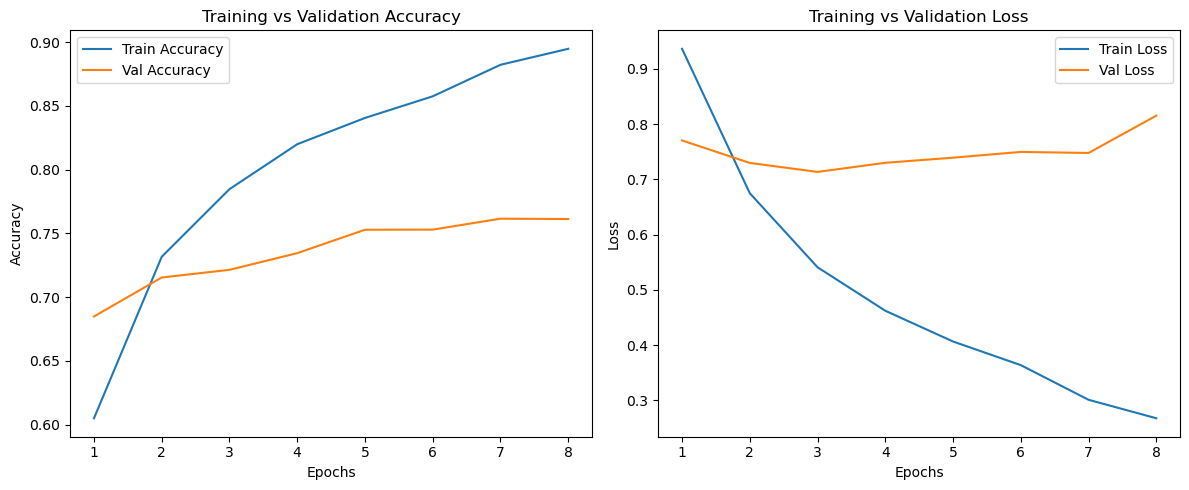

In [31]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7240 - loss: 0.6937
Test Accuracy: 0.7214
Test Loss: 0.7135


354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step
              precision    recall  f1-score   support

        Bach       0.85      0.86      0.85      3278
   Beethoven       0.78      0.54      0.64      3663
      Chopin       0.71      0.84      0.77      2358
      Mozart       0.53      0.69      0.60      2017

    accuracy                           0.72     11316
   macro avg       0.71      0.73      0.71     11316
weighted avg       0.74      0.72      0.72     11316



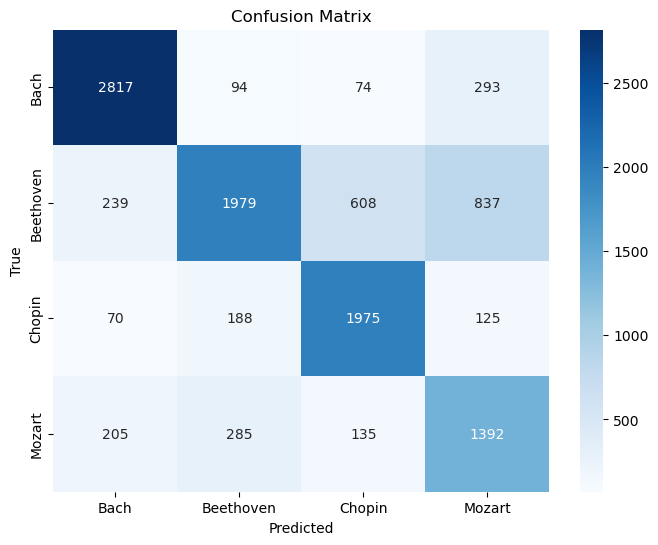

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

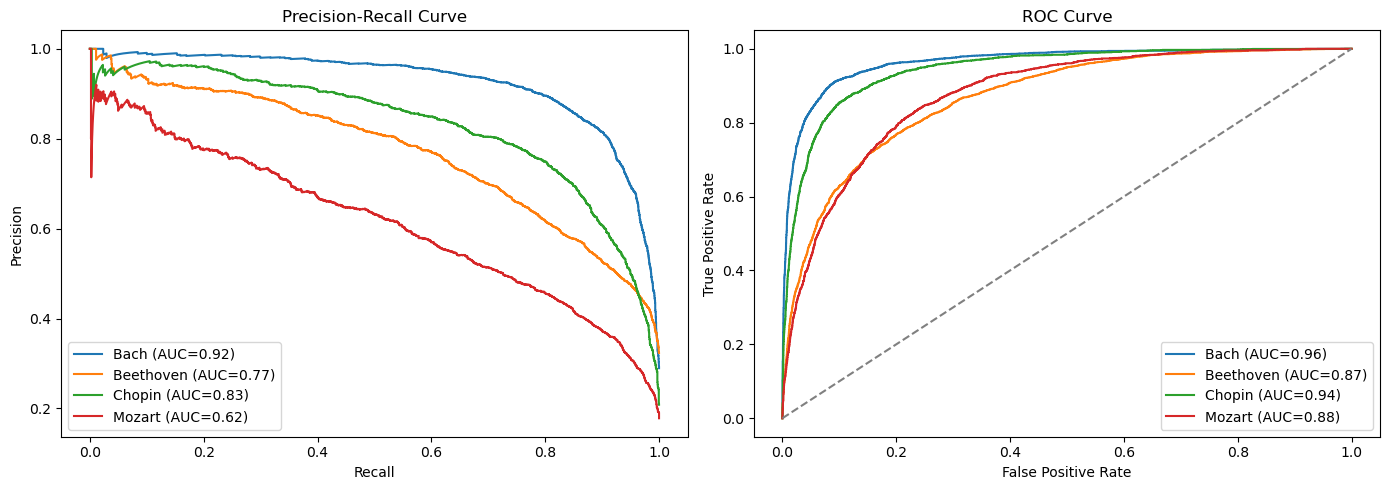

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # shape: (n_samples, n_classes)

# Initialize plots
plt.figure(figsize=(14, 5))

# Precision-Recall Curve 
plt.subplot(1, 2, 1)
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{encoder.classes_[i]} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# ROC Curve
plt.subplot(1, 2, 2)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{encoder.classes_[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()